# Clustering and Classifition with PySpark Module

## Student no : 21526638
## Student name : Okan ALAN

Preparing the needed modules and dataset

In [0]:
# colab restarts itself every day. I mount my Google Drive to not upload the dataset to colab every day.
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# install spark and pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Purpuse

In this assignment, our goal was to learn clustering and classification with PySpark. During this time, they expected us to learn algorithms in those topics.

![start](https://media.giphy.com/media/Ln2dAW9oycjgmTpjX9/giphy.gif)

Firstly, let's start with importing necessary libraries/functions

In [3]:
import os
rootPath="/content/gdrive/My Drive/dataintensive/"

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, MinMaxScaler,IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

from pyspark.sql import SQLContext
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import *

sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# DATASET ANALYSIS

The dataset is too understandable. Features are computed from a digitized image of a fine needle aspirate(FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

In [4]:
# what we have
od=pd.read_csv(rootPath+"data/data.csv", sep=',')
print(od.shape)
print(od.info())

(569, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se    

Examine the correlation of features

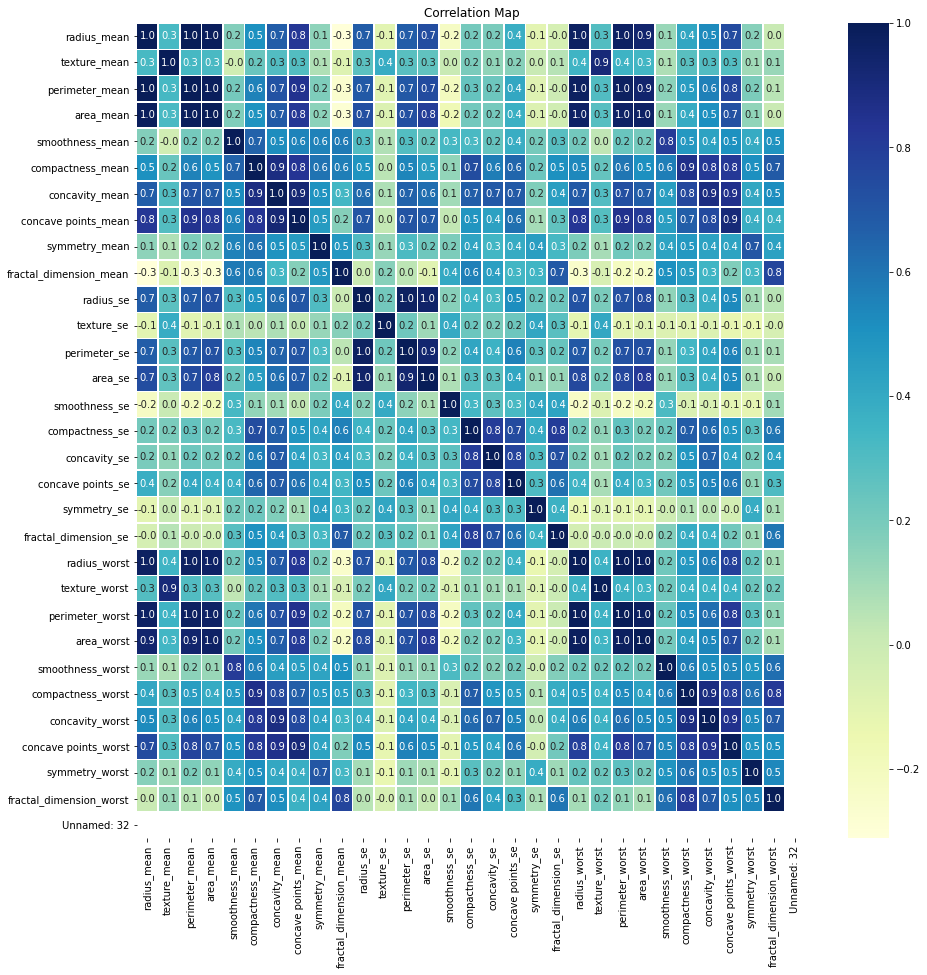

In [5]:
f,ax=plt.subplots(figsize = (15,15))
sns.heatmap(od.iloc[:,1:].corr(),annot= True,linewidths=0.5,fmt = ".1f", ax=ax, cmap="YlGnBu")
plt.title('Correlation Map')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

As can be seen from the correlation map above, most of the features are highly correlated. If we eliminate some of them, we may take better result when we cluster or classify our dataset. Let's try feature extraction.

Pre-processing steps for our dataset

In [6]:
#first column is contains ill id 
#last column contain only nan value due to extra delimeter end of line
od = od.drop(od.columns[[0,32]],axis=1)

# # M(malignant) = 0 and B(benign) = 1 enumeration for more accurty results 
od['diagnosis'] = od['diagnosis'].map({'M':0,'B':1})

od = od.dropna()

od.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Feature Selection via CHI Square

The chi-square test helps you to solve the problem in feature selection by testing the relationship between the features. In this article, I will guide through.

A chi-square test is used in statistics to test the independence of two events. Given the data of two variables, we can get observed count O and expected count E. Chi-Square measures how expected count E and observed count O deviates each other.

*In feature selection, we aim to select the features which are highly dependent on the response.*

In [7]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(od.drop(columns="diagnosis"), od.diagnosis, test_size=0.3, random_state=42)

select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)

print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

zipped = set(zip(x_train.columns,select_feature.scores_))
zipped = sorted(zipped, key=lambda x:x[1], reverse=True)
SELECTED_FEATURES_COL = []
for z in zipped[:5]:
  SELECTED_FEATURES_COL.append(z[0])
print("SELECTED FEATURES :",SELECTED_FEATURES_COL)

Score list: [1.77946492e+02 6.06916433e+01 1.34061092e+03 3.66899557e+04
 1.00015175e-01 3.41839493e+00 1.30547650e+01 7.09766457e+00
 1.95982847e-01 3.42575072e-04 2.45882967e+01 4.07131026e-02
 1.72696840e+02 6.12741067e+03 1.32470372e-03 3.74071521e-01
 6.92896719e-01 2.01587194e-01 1.39557806e-03 2.65927071e-03
 3.25782599e+02 1.16958562e+02 2.40512835e+03 7.50217341e+04
 2.63226314e-01 1.19077581e+01 2.58858117e+01 8.90751003e+00
 1.00635138e+00 1.23087347e-01]
Feature list: Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'c

What did we learn from chi square feature selection? According to chi square, 'area_worst', 'area_mean', 'area_se', 'perimeter_worst', 'perimeter_mean' are highly correlated in our dataset. We will learn the effect of these selected features on our models.

# CLUSTERING

Clustering data means that collecting the similar data records into one cluster. Clustering is a unsupervised learning model. Our dataset is already labeled data therefore I am not totaly sure my clustering results. I am not sure how okay it is to apply clustering to this data. My clustering method was KMeans.

There are some functions that I coded. We are clustering dataset twice; one for original dataset, another for normalized dataset. Therefore, I thought if I put some code snippets together, the person who will read my homework can understand my assignment easily. Also, some functions are used for the classification.

In [0]:
def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

# pre-processing the data
def prepareSparkDataFrame(cc):

  #read dataset
  path = rootPath+'data/data.csv'
  df = sqlContext.read.csv(path, header=True)
  #delete last empty column
  df = df.drop(*["_c32"])

  # rearrange id column
  df = df.select("*").withColumn("id", monotonically_increasing_id())

  if cc == "cluster":
    mapping = {"M":0, "B":1}
    df = df.withColumn("diagnosis", translate(mapping)("diagnosis"))
  elif cc== "classify":
    df = df.drop(*["id"])

  # string to float
  for col in df.columns[1:]:
        df = df.withColumn(col,df[col].cast('float'))

  #drop null rows
  df = df.na.drop()

  return df

#prepare the dataframe for clustering
def clusterKmeans(df,FEATURES_COL):
  
  vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
  df_kmeans = vecAssembler.transform(df).select('id', 'features')

  # Determine KMEANS Model's Centers
  k = 2
  kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
  model = kmeans.fit(df_kmeans)
  centers = model.clusterCenters()

  # determine clusters' element
  transformed = model.transform(df_kmeans).select('id', 'prediction')
  # rows is our prediction result
  rows = transformed.collect()
  
  return df_kmeans, rows

# pyspark dataframe to pandas dataframe in order to visualization
def df2pddf(rows,df):
  
  _df_pred = sqlContext.createDataFrame(rows)

  _pddf_df = df.toPandas().set_index("id")
  _pddf_pred = _df_pred.toPandas().set_index("id")

  return _pddf_df, _pddf_pred

def visualize_Kmeans(df_kmeans,pddf_df,pddf_pred,left_title,right_title):

  X = pddf_df.drop('diagnosis', axis=1).values
  X = StandardScaler().fit_transform(X)
  # Scatter plots  https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.scatter.html
  f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,10), sharey=True)
  ax1.scatter(X[:,0], X[:,1], c=pddf_df["diagnosis"], cmap="jet",edgecolor="none", alpha=0.35)
  ax1.set_title(left_title)
  ax2.scatter(X[:,0], X[:,1], c=pddf_pred["prediction"], cmap="jet", edgecolor="none", alpha=0.35)
  ax2.set_title(right_title)
  
  return f

# Visualize F1 Score of KMeans
def results_Kmeans(pddf_df,pddf_pred,explanation):
  
  precision, recall, F1, noe = precision_recall_fscore_support(pddf_df[["diagnosis"]], pddf_pred[["prediction"]], average='macro')
  acc = accuracy_score(pddf_df[["diagnosis"]], pddf_pred[["prediction"]])
  cf_matrix = confusion_matrix(pddf_df[["diagnosis"]], pddf_pred[["prediction"]])
  if F1 < 0.5:
    F1=1-F1
    precision = 1-precision
    recall = 1-recall
    acc = 1-acc
    cf_matrix[0][0],cf_matrix[0][1]=cf_matrix[0][1],cf_matrix[0][0]
    cf_matrix[1][0],cf_matrix[1][1]=cf_matrix[1][1],cf_matrix[1][0] 

  print(explanation)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", F1)
  print("Accuracy:", acc)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


def normalizeDataSet(df,normBegin):

  columns_to_scale = df.columns[normBegin:]
  assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
  scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
  pipeline = Pipeline(stages=assemblers + scalers)
  scalerModel = pipeline.fit(df)
  scaledData = scalerModel.transform(df)
  return scaledData

# after normalization, the type of the column was being dense vector
def denseVector2float(df,FEATURES_COL):
  
  firstelement=udf(lambda v:float(v[0]),FloatType())
  for col in FEATURES_COL:
    df = df.withColumn(col,firstelement(col))
    df = df.withColumn(col,df[col].cast('float'))
  return df


## ORIGINAL DATASET

In [9]:
#READ, APPLY PREPROCESSING
df = prepareSparkDataFrame("cluster")
FEATURES_COL = df.columns[1:]
df.show()

+---+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
| id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---+---------+-----------+------------+--------------+---

Cluster the original dataset

In [10]:
df_kmeans, rows = clusterKmeans(df,FEATURES_COL)
df_kmeans.show()
rows[:5]

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.0,17.989999771...|
|  1|[0.0,20.569999694...|
|  2|[0.0,19.690000534...|
|  3|[0.0,11.420000076...|
|  4|[0.0,20.290000915...|
|  5|[0.0,12.449999809...|
|  6|[0.0,18.25,19.979...|
|  7|[0.0,13.710000038...|
|  8|[0.0,13.0,21.8199...|
|  9|[0.0,12.460000038...|
| 10|[0.0,16.020000457...|
| 11|[0.0,15.779999732...|
| 12|[0.0,19.170000076...|
| 13|[0.0,15.850000381...|
| 14|[0.0,13.729999542...|
| 15|[0.0,14.539999961...|
| 16|[0.0,14.680000305...|
| 17|[0.0,16.129999160...|
| 18|[0.0,19.809999465...|
| 19|[1.0,13.539999961...|
+---+--------------------+
only showing top 20 rows



[Row(id=0, prediction=0),
 Row(id=1, prediction=0),
 Row(id=2, prediction=0),
 Row(id=3, prediction=1),
 Row(id=4, prediction=0)]

I clustered the original data set and took the cluster to learn accuracy of the model. 

Visualization KMEANS on Original Dataset

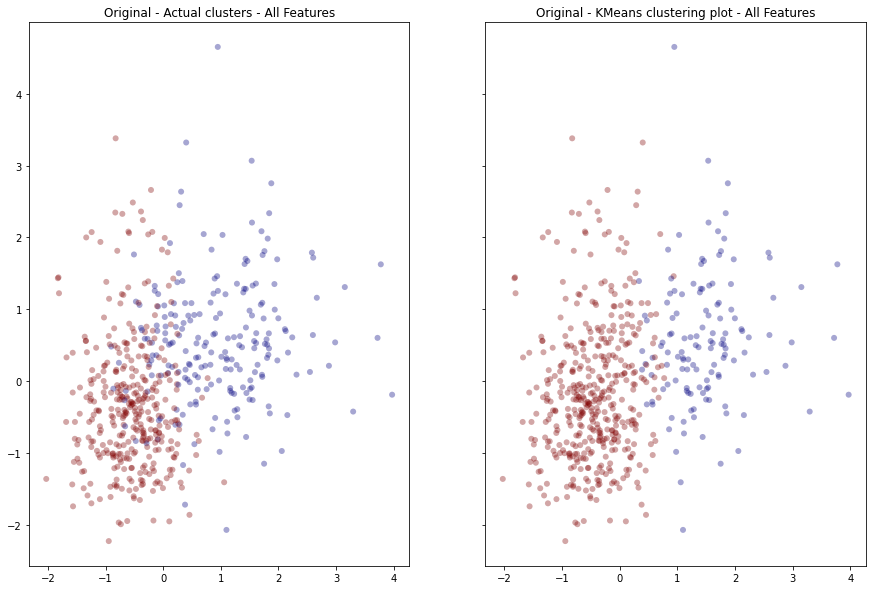

In [11]:
pddf_df, pddf_pred = df2pddf(rows,df)
f = visualize_Kmeans(df_kmeans,pddf_df, pddf_pred, "Original - Actual clusters - All Features","Original - KMeans clustering plot - All Features")

Above plots show us how clustered our original dataset.

ORIGINAL DATASET - ALL FEATURES
Precision: 0.9025759001707971
Recall: 0.805203213360816
F1 Score: 0.82680748849405
Accuracy: 0.8541300527240774


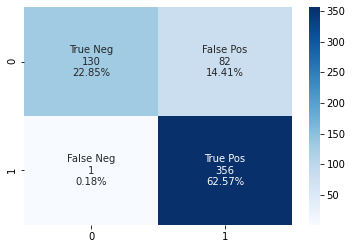

In [14]:
results_Kmeans(pddf_df,pddf_pred,"ORIGINAL DATASET - ALL FEATURES")

## NORMALIZED DATASET

I will also follow the same steps applied to the original dataset to the normalized dataset.

In [15]:
norm_df = prepareSparkDataFrame("cluster")
norm_df = normalizeDataSet(norm_df,2)
#len(norm_df.columns)
norm_df = norm_df.drop(*norm_df.columns[2:62])
norm_FEATURES_COL = norm_df.columns[1:]
norm_df = denseVector2float(norm_df,norm_FEATURES_COL[1:])
norm_df.show()

+---+---------+------------------+-------------------+---------------------+----------------+----------------------+-----------------------+---------------------+--------------------------+--------------------+-----------------------------+----------------+-----------------+-------------------+--------------+--------------------+---------------------+-------------------+------------------------+------------------+---------------------------+-------------------+--------------------+----------------------+-----------------+-----------------------+------------------------+----------------------+---------------------------+---------------------+------------------------------+
| id|diagnosis|radius_mean_scaled|texture_mean_scaled|perimeter_mean_scaled|area_mean_scaled|smoothness_mean_scaled|compactness_mean_scaled|concavity_mean_scaled|concave points_mean_scaled|symmetry_mean_scaled|fractal_dimension_mean_scaled|radius_se_scaled|texture_se_scaled|perimeter_se_scaled|area_se_scaled|smoothnes

Cluster the original dataset

In [16]:
norm_df_kmeans, norm_rows = clusterKmeans(norm_df,norm_FEATURES_COL)
norm_df_kmeans.show()
norm_rows[:5]

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.0,0.5210373997...|
|  1|[0.0,0.6431444883...|
|  2|[0.0,0.6014955639...|
|  3|[0.0,0.2100903987...|
|  4|[0.0,0.6298925876...|
|  5|[0.0,0.2588385343...|
|  6|[0.0,0.5333427786...|
|  7|[0.0,0.3184722363...|
|  8|[0.0,0.2848691344...|
|  9|[0.0,0.2593118548...|
| 10|[0.0,0.4278006553...|
| 11|[0.0,0.4164418280...|
| 12|[0.0,0.5768848657...|
| 13|[0.0,0.4197548329...|
| 14|[0.0,0.3194187879...|
| 15|[0.0,0.3577547371...|
| 16|[0.0,0.3643807172...|
| 17|[0.0,0.4330067038...|
| 18|[0.0,0.6071749329...|
| 19|[1.0,0.3104264140...|
+---+--------------------+
only showing top 20 rows



[Row(id=0, prediction=1),
 Row(id=1, prediction=1),
 Row(id=2, prediction=1),
 Row(id=3, prediction=1),
 Row(id=4, prediction=1)]

Visualization KMEANS on Original Dataset

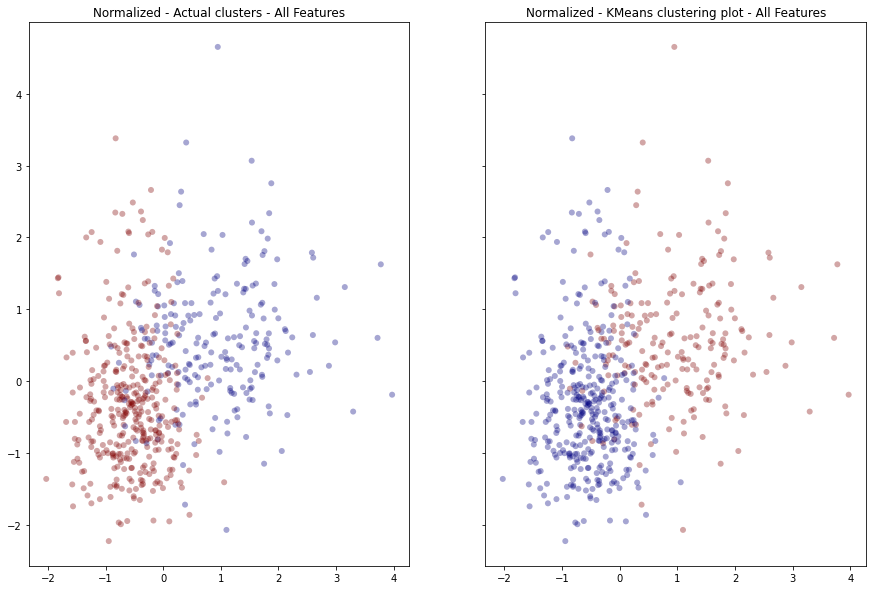

In [17]:
norm_pddf_df, norm_pddf_pred = df2pddf(norm_rows,norm_df)
norm_f = visualize_Kmeans(norm_df_kmeans, norm_pddf_df, norm_pddf_pred, "Normalized - Actual clusters - All Features","Normalized - KMeans clustering plot - All Features")

NORMALIZED DATASET - ALL FEATURES
Precision: 0.9986033519553073
Recall: 0.9976415094339622
F1 Score: 0.9982456140350877
Accuracy: 0.9982425307557118


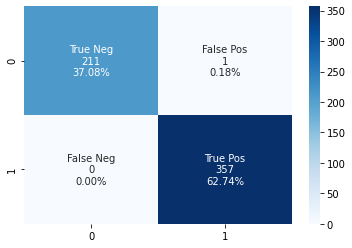

In [18]:
results_Kmeans(norm_pddf_df,norm_pddf_pred,"NORMALIZED DATASET - ALL FEATURES")

Wooow. In normalized dataset, we clustered only 1 record wrongly. In orginal dataset, I had 83 failed record.

|Clustering|Precision|Recall|F1|Accuracy|
|-|-|-|-|-|
|Original|0.90|0.80|0.82|0.85|
|Normalized|0.99|0.99|0.99|0.99|


![End Of Clustering](https://media.giphy.com/media/26tjZAQBMhxNF0M4o/giphy.gif)

# CLASSIFICATION

There are some functions that I coded. We classify dataset three times; first one for original dataset, the second one for normalized dataset, the last one for original data set that contain selected features. Therefore, I thought if I put some code snippets together, the person who will read my homework can understand my assignment easily.

In [0]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[1:]),r[0]]).toDF(['features','label'])

#preparing dataset for Logistic Regression Classification
def preparePipeline(transformed):
  
  labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
  # labelIndexer.transform(transformed).show()

  featureIndexer =VectorIndexer(inputCol="features", \
                                outputCol="indexedFeatures", \
                                maxCategories=2).fit(transformed)
  # featureIndexer.transform(transformed).show(5)

  logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')
  labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                                labels=labelIndexer.labels)
  pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

  return pipeline

# Visualize F1 Score
def result_Classify(predictions,explanation):
  
  class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
  class_temp = class_temp["label"].values.tolist()
  class_names = map(str, class_temp)

  y_true = predictions.select("label")
  y_true = y_true.toPandas()

  y_pred = predictions.select("predictedLabel")
  y_pred = y_pred.toPandas()

  precision, recall, F1, noe = precision_recall_fscore_support(y_true, y_pred, average='macro')
  cf_matrix = confusion_matrix(y_true, y_pred)
  acc = accuracy_score(y_true, y_pred)
  
  if F1 < 0.5:
    F1=1-F1
    precision = 1-precision
    recall = 1-recall
    acc=1-acc
    cf_matrix[0][0],cf_matrix[0][1]=cf_matrix[0][1],cf_matrix[0][0]
    cf_matrix[1][0],cf_matrix[1][1]=cf_matrix[1][1],cf_matrix[1][0]
  print(explanation)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", F1)
  print("Accuracy:",acc)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## ORIGINAL DATASET

In [20]:
df = prepareSparkDataFrame("classify")
df.show()
# df.printSchema()

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

Transform Dataset: Generating a vector from values of record.

In [21]:
transformed = transData(df)
transformed.show(5)

pipeline = preparePipeline(transformed)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[17.9899997711181...|    M|
|[20.5699996948242...|    M|
|[19.6900005340576...|    M|
|[11.4200000762939...|    M|
|[20.2900009155273...|    M|
+--------------------+-----+
only showing top 5 rows



Split dataset by 2 into train and test

In [22]:
(trainingData, testingData) = transformed.randomSplit([0.7, 0.3])

trainingData.show(5,False)
testingData.show(5,False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                            

Classify the test dataset and visualize result

ORIGINAL DATASET CLASSIFICATION RESULTS
Precision: 0.9357142857142857
Recall: 0.9451626355296081
F1 Score: 0.9398708081363387
Accuracy: 0.9428571428571428


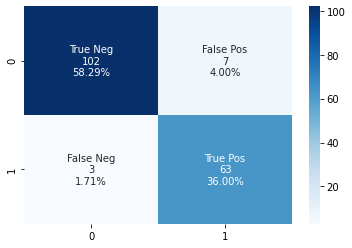

In [25]:
model = pipeline.fit(trainingData)

predictions = model.transform(testingData)

# Select example rows to display.
#predictions.select("features","label","predictedLabel").show()

result_Classify(predictions,"ORIGINAL DATASET CLASSIFICATION RESULTS")

## NORMALIZED DATASET

I will also follow the same steps applied to the original dataset to the normalized dataset.

In [26]:
norm_df = prepareSparkDataFrame("classify")
(norm_trainingData,norm_testingData) = norm_df.randomSplit([0.7, 0.3])

norm_trainingData = normalizeDataSet(norm_trainingData,1)
norm_trainingData = norm_trainingData.drop(*norm_trainingData.columns[1:61])
norm_FEATURES_COL = norm_trainingData.columns[:]
norm_trainingData = denseVector2float(norm_trainingData,norm_FEATURES_COL[1:])
norm_trainingData.show(5)

norm_testingData = normalizeDataSet(norm_testingData,1)
norm_testingData = norm_testingData.drop(*norm_testingData.columns[1:61])
norm_FEATURES_COL = norm_testingData.columns[:]
norm_testingData = denseVector2float(norm_testingData,norm_FEATURES_COL[1:])
norm_testingData.show(5)

+---------+------------------+-------------------+---------------------+----------------+----------------------+-----------------------+---------------------+--------------------------+--------------------+-----------------------------+----------------+-----------------+-------------------+--------------+--------------------+---------------------+-------------------+------------------------+------------------+---------------------------+-------------------+--------------------+----------------------+-----------------+-----------------------+------------------------+----------------------+---------------------------+---------------------+------------------------------+
|diagnosis|radius_mean_scaled|texture_mean_scaled|perimeter_mean_scaled|area_mean_scaled|smoothness_mean_scaled|compactness_mean_scaled|concavity_mean_scaled|concave points_mean_scaled|symmetry_mean_scaled|fractal_dimension_mean_scaled|radius_se_scaled|texture_se_scaled|perimeter_se_scaled|area_se_scaled|smoothness_se_sca

Transform Normalized Dataset: Generating a vector from values of record.

In [27]:
norm_trainingData = transData(norm_trainingData)
norm_trainingData.show(5)

norm_testingData = transData(norm_testingData)
norm_testingData.show(5)

norm_pipeline = preparePipeline(norm_trainingData.union(norm_testingData))

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.5336489677...|    B|
|[0.02291349694132...|    B|
|[0.02404198795557...|    B|
|[0.04263772442936...|    B|
|[0.04931063577532...|    B|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.1285714507...|    B|
|[0.03508078679442...|    B|
|[0.03849006071686...|    B|
|[0.07856120169162...|    B|
|[0.07984585314989...|    B|
+--------------------+-----+
only showing top 5 rows



Classify the normalized test set and visualize result

NORMALIZED DATASET CLASSIFICATION RESULTS
Precision: 0.8432234432234432
Recall: 0.8690913865546219
F1 Score: 0.8504149899396378
Accuracy: 0.8579234972677595


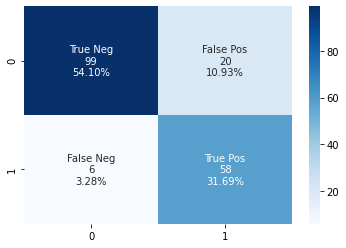

In [28]:
norm_model = norm_pipeline.fit(norm_trainingData)

norm_predictions = norm_model.transform(norm_testingData)

# Select example rows to display.
#norm_predictions.select("features","label","predictedLabel").show()

result_Classify(norm_predictions,"NORMALIZED DATASET CLASSIFICATION RESULTS")

Unlike clustering, the results are the opposite here. This time original dataset's result is better.

## SELECTED FEATURE CLASSIFICATION

I got worst result when I normalized original dataset. What will it happend if I work on selected features that are coming from chi square feature selection? Also, I followed the same steps applied to the original dataset to the selected features dataset.

In [33]:
sel_df = prepareSparkDataFrame("classify")
_sf = ["diagnosis"]+SELECTED_FEATURES_COL
sel_df = sel_df.select(*_sf)
sel_df.show()

+---------+----------+---------+-------+---------------+--------------+
|diagnosis|area_worst|area_mean|area_se|perimeter_worst|perimeter_mean|
+---------+----------+---------+-------+---------------+--------------+
|        M|    2019.0|   1001.0|  153.4|          184.6|         122.8|
|        M|    1956.0|   1326.0|  74.08|          158.8|         132.9|
|        M|    1709.0|   1203.0|  94.03|          152.5|         130.0|
|        M|     567.7|    386.1|  27.23|          98.87|         77.58|
|        M|    1575.0|   1297.0|  94.44|          152.2|         135.1|
|        M|     741.6|    477.1|  27.19|          103.4|         82.57|
|        M|    1606.0|   1040.0|  53.91|          153.2|         119.6|
|        M|     897.0|    577.9|  50.96|          110.6|          90.2|
|        M|     739.3|    519.8|  24.32|          106.2|          87.5|
|        M|     711.4|    475.9|  23.94|          97.65|         83.97|
|        M|    1150.0|    797.8|  40.51|          123.8|        

We see the dataset containing the features selected above.

Transform Limitted Dataset: Generating a vector from values of record.

In [34]:
sel_transformed = transData(df)
sel_transformed.show(5)

sel_pipeline = preparePipeline(sel_transformed)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[17.9899997711181...|    M|
|[20.5699996948242...|    M|
|[19.6900005340576...|    M|
|[11.4200000762939...|    M|
|[20.2900009155273...|    M|
+--------------------+-----+
only showing top 5 rows



In [35]:
(sel_trainingData, sel_testingData) = sel_transformed.randomSplit([0.7, 0.3])

sel_trainingData.show(5,False)
sel_testingData.show(5,False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                           

Classify the limitted test set and visualize result

SELECTED FEATURES DATASET CLASSIFICATION RESULTS
Precision: 0.9643243243243242
Recall: 0.9686022548187658
F1 Score: 0.9663368725868726
Accuracy: 0.967741935483871


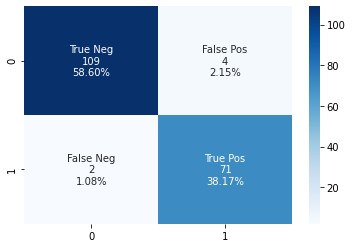

In [36]:
sel_model = sel_pipeline.fit(sel_trainingData)

sel_predictions = sel_model.transform(sel_testingData)

result_Classify(sel_predictions,"SELECTED FEATURES DATASET CLASSIFICATION RESULTS")

Oooo. Feature selection is worked. I got better result.

|Classification|Precision|Recall|F1|Accuracy|
|-|-|-|-|-|
|Original|0.936|0.945|0.939|0.943|
|Normalized|0.843|0.869|0.850|0.858|
|Selected Features|0.964|0.968|0.966|0.968|

![link text](https://media.giphy.com/media/l2JdVRfJozpjq70SA/giphy.gif) 